In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params, w_set='K2166'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{w_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{w_set}.pkl')

    try:
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{w_set}.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{w_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{w_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{w_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [2]:
#prefix_1 = './retrieval_outputs/reference_diff_rot_K_B_ret_7/test_'
#w_set = 'K2166'
#n_params = 24
prefix_1 = './retrieval_outputs/equatorial_band_K_B_ret_4/test_'
w_set = 'K2166'
n_params = 26

res = read_results(prefix=prefix_1, n_params=n_params, w_set=w_set)
posterior_1, bestfit_1, PT_1, Chem_1, _, _, _, m_spec_1, d_spec_1, LogLike_1, Cov_1, bestfit_params_1 = res
del res

prefix_2 = './retrieval_outputs/equatorial_band_K_B_ret_5/test_'
w_set = 'K2166'
n_params = 26

res = read_results(prefix=prefix_2, n_params=n_params, w_set=w_set)
posterior_2, bestfit_2, PT_2, Chem_2, _, _, _, m_spec_2, d_spec_2, LogLike_2, Cov_2, bestfit_params_2 = res
del res

  analysing data from ./retrieval_outputs/equatorial_band_K_B_ret_4/test_.txt
(868, 26)
  analysing data from ./retrieval_outputs/equatorial_band_K_B_ret_5/test_.txt
(915, 26)


In [3]:
import copy
from tqdm import tqdm
import petitRADTRANS.nat_cst as nc

from scipy.ndimage import gaussian_filter1d

def get_pRT_atm(prefix, w_set, bestfit_params, Chem, PT, vsini_local=0, line_species=None):

    pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_broad_{w_set}.pkl')

    # Compute global model spectrum
    params_global = copy.deepcopy(bestfit_params['params'])
    pRT_atm.params = params_global

    m_spec_global = pRT_atm(Chem.mass_fractions, PT.temperature, params_global, get_contr=False, get_full_spectrum=True)
    m_spec_global.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_global.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    Rot = copy.copy(pRT_atm.Rot)

    # Compute local model spectrum
    params_local = copy.deepcopy(params_global)
    params_local['vsini'] = vsini_local
    params_local['lat_band'] = None
    params_local['lat_band_upper'] = 90
    params_local['epsilon_band'] = 1
    pRT_atm.params = params_local

    # Local abundances
    mf_local = Chem.mass_fractions.copy()
    if line_species is not None:
        
        for key_i in mf_local.keys():
            # Set abundances of other species to 0
            if key_i != line_species:
                mf_local[key_i] *= 0

    m_spec_local = pRT_atm(mf_local, PT.temperature, params_local, get_contr=False, get_full_spectrum=True)
    m_spec_local.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_local.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    return m_spec_global, m_spec_local, Rot

def get_CCF(
        d_spec, m_spec_local, m_spec_global, LogLike, Cov, rv=np.arange(-200,200+1e-6,1), 
        subtract_global_from_template=False, filter_width=100, return_CCF_on_data=False
        ):
    
    CCF = np.nan * np.ones(
        (len(rv), d_spec.n_orders, d_spec.n_dets)
        )
    
    d_wave = np.copy(d_spec.wave)
    d_res  = np.copy(d_spec.flux) - LogLike.f[:,:,None]*m_spec_global.flux
    
    # Apply high-pass filter to the residuals
    mask = d_spec.mask_isfinite

    lp_d_res = np.nan*np.ones_like(d_res)
    lp_d_res[mask] = gaussian_filter1d(
        d_res[mask], sigma=filter_width, axis=-1, mode='nearest'
        )
    d_res -= lp_d_res

    if return_CCF_on_data:
        CCF_on_data = np.nan * np.ones(
            (len(rv), d_spec.n_orders, d_spec.n_dets)
            )
        
        # Apply high-pass filter to the observed spectrum
        d_flux = np.copy(d_spec.flux)
        lp_d_flux = np.nan*np.ones_like(d_flux)
        lp_d_flux[mask] = gaussian_filter1d(
            d_flux[mask], sigma=filter_width, axis=-1, mode='nearest'
            )
        d_flux -= lp_d_flux
        del lp_d_res, lp_d_flux

    for i, rv_i in enumerate(tqdm(rv)):

        for j in range(d_spec.n_orders):
            
            # Shift the model spectrum
            m_wave_local = np.copy(m_spec_local.wave_pRT_grid[j])
            m_wave_local *= (1 + rv_i/(nc.c*1e-5))

            m_flux_local = np.copy(m_spec_local.flux_pRT_grid[j])

            for k in range(d_spec.n_dets):

                # Subtract the global model?
                if subtract_global_from_template:
                    m_res_local_jk = LogLike.f[j,k] * (m_flux_local - m_spec_global.flux_pRT_grid[j])
                else:
                    m_res_local_jk = LogLike.f[j,k] * m_flux_local
                
                # Optimal scaling
                #m_res_local *= LogLike.f[j,:][:,None]
                
                # Don't consider the nans
                mask_jk = d_spec.mask_isfinite[j,k]

                if not mask_jk.any():
                    continue

                # Interpolate onto the data wavelength grid
                m_res_local_jk = np.interp(
                    d_wave[j,k], xp=m_wave_local, fp=m_res_local_jk
                    )
                
                lp_m_res_local_jk = np.nan*np.ones_like(m_res_local_jk)
                lp_m_res_local_jk[mask_jk] = gaussian_filter1d(
                    m_res_local_jk[mask_jk], sigma=filter_width, axis=-1, mode='nearest'
                    )
                m_res_local_jk -= lp_m_res_local_jk

                #plt.figure(figsize=(12,3))
                #plt.plot(d_wave[j,k], d_flux[j,k], c='C0', lw=0.5)
                #plt.plot(d_wave[j,k], d_res[j,k], c='k', lw=0.5)
                #plt.plot(d_wave[j,k], m_res_local_jk/15, c='C1')
                #plt.show()
                
                # Compute the covariance-weighted dot-product
                CCF[i,j,k] = np.dot(
                    m_res_local_jk[mask_jk], 1/LogLike.beta[j,k]**2 * Cov[j,k].solve(d_res[j,k,mask_jk])
                    )
                
                if return_CCF_on_data:
                    CCF_on_data[i,j,k] = np.dot(
                        m_res_local_jk[mask_jk], 1/LogLike.beta[j,k]**2 * Cov[j,k].solve(d_flux[j,k,mask_jk])
                        )

    if return_CCF_on_data:
        return CCF, CCF_on_data, rv
    else:
        return CCF, rv

def get_profile(params, Rot, fwhm=0.05):

    # Define the un-broadened profile
    from astropy.modeling.models import Lorentz1D
    wave = np.arange(2000-2,2000+2,0.01)
    profile = np.ones_like(wave)
    profile -= Lorentz1D(amplitude=0.5, x_0=2000, fwhm=fwhm)(wave)

    # Broaden the profile
    profile_broad = Rot(wave, profile, params, f_grid=Rot.f_grid, get_scaling=False)
    profile_broad /= np.pi

    return wave, profile_broad, profile

In [4]:
m_spec_global_1, m_spec_local_1, Rot_1 = get_pRT_atm(prefix_1, w_set, bestfit_params_1, copy.deepcopy(Chem_1), PT_1)
m_spec_global_2, m_spec_local_2, Rot_2 = get_pRT_atm(prefix_2, w_set, bestfit_params_2, copy.deepcopy(Chem_2), PT_2)

wave, profile_broad_1, profile = get_profile(
    params=bestfit_params_1['params'], Rot=copy.deepcopy(Rot_1)
    )
wave, profile_broad_2, profile = get_profile(
    params=bestfit_params_2['params'], Rot=copy.deepcopy(Rot_2)
    )

CCF_1, CCF_on_data_1, rv = get_CCF(
    d_spec_1, m_spec_local_1, m_spec_global_1, LogLike_1, Cov_1, return_CCF_on_data=True
    )
CCF_2, CCF_on_data_2, rv = get_CCF(
    d_spec_2, m_spec_local_2, m_spec_global_2, LogLike_2, Cov_2, return_CCF_on_data=True
    )

AttributeError: Can't get attribute 'RotationProfile' on <module 'retrieval_base.pRT_model' from '/home/sam/Documents/PhD/CRIRES_data_reduction/retrieval_base/retrieval_base/pRT_model.py'>

In [5]:
_, m_spec_local_1_CH4, _ = get_pRT_atm(prefix_1, w_set, bestfit_params_1, copy.deepcopy(Chem_1), PT_1, line_species='CH4_hargreaves_main_iso')
CCF_1_CH4, rv = get_CCF(
    d_spec_1, m_spec_local_1_CH4, m_spec_global_1, LogLike_1, Cov_1, 
    )

_, m_spec_local_2_CH4, _ = get_pRT_atm(prefix_2, w_set, bestfit_params_2, copy.deepcopy(Chem_2), PT_2, line_species='CH4_hargreaves_main_iso')
CCF_2_CH4, rv = get_CCF(
    d_spec_2, m_spec_local_2_CH4, m_spec_global_2, LogLike_2, Cov_2, 
    )

del m_spec_local_1_CH4, m_spec_local_2_CH4

100%|██████████| 401/401 [00:01<00:00, 253.03it/s]


In [6]:
_, m_spec_local_1_CO, _ = get_pRT_atm(prefix_1, w_set, bestfit_params_1, copy.deepcopy(Chem_1), PT_1, line_species='CO_main_iso')
CCF_1_CO, rv = get_CCF(
    d_spec_1, m_spec_local_1_CO, m_spec_global_1, LogLike_1, Cov_1, 
    )

_, m_spec_local_2_CO, _ = get_pRT_atm(prefix_2, w_set, bestfit_params_2, copy.deepcopy(Chem_2), PT_2, line_species='CO_main_iso')
CCF_2_CO, rv = get_CCF(
    d_spec_2, m_spec_local_2_CO, m_spec_global_2, LogLike_2, Cov_2, 
    )

del m_spec_local_1_CO, m_spec_local_2_CO

100%|██████████| 401/401 [00:01<00:00, 261.96it/s]


In [7]:
_, m_spec_local_1_H2O, _ = get_pRT_atm(prefix_1, w_set, bestfit_params_1, copy.deepcopy(Chem_1), PT_1, line_species='H2O_pokazatel_main_iso')
CCF_1_H2O, rv = get_CCF(
    d_spec_1, m_spec_local_1_H2O, m_spec_global_1, LogLike_1, Cov_1, 
    )

_, m_spec_local_2_H2O, _ = get_pRT_atm(prefix_2, w_set, bestfit_params_2, copy.deepcopy(Chem_2), PT_2, line_species='H2O_pokazatel_main_iso')
CCF_2_H2O, rv = get_CCF(
    d_spec_2, m_spec_local_2_H2O, m_spec_global_2, LogLike_2, Cov_2, 
    )

del m_spec_local_1_H2O, m_spec_local_2_H2O

100%|██████████| 401/401 [00:01<00:00, 223.46it/s]


In [8]:
def orthographic_to_xy(lat, lon, lat_0, lon_0, R=1):

    x = R * np.cos(lat) * np.sin(lon-lon_0)
    y = R * (np.cos(lat_0)*np.sin(lat) - np.sin(lat_0)*np.cos(lat)*np.cos(lon-lon_0))

    c = np.arccos(
        np.sin(lat_0)*np.sin(lat) + np.cos(lat_0)*np.cos(lat)*np.cos(lon-lon_0)
    )

    mask = (c > -np.pi/2) & (c < np.pi/2)
    x[~mask] = np.nan
    y[~mask] = np.nan
    return x, y, c

def plot_grid(ax, lat_grid=np.arange(-90,90+1e-6,30), lon_grid=np.arange(0,360,30), inclination=26, lon_0=0, **kwargs):

    lat = np.deg2rad(np.linspace(-90,90,100))
    lon = np.deg2rad(np.linspace(0,360,100))

    inclination = np.deg2rad(inclination)
    lon_0 = np.deg2rad(lon_0)

    for lat_i in np.deg2rad(lat_grid):

        # Orthographic projection
        x, y, c = orthographic_to_xy(lat_i, lon, inclination, lon_0)

        # Convert to polar coordinates
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)

        ax.plot(phi, r, **kwargs)

    for lon_i in np.deg2rad(lon_grid):
        
        # Orthographic projection
        x, y, c = orthographic_to_xy(lat, lon_i, inclination, lon_0)

        # Convert to polar coordinates
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)

        ax.plot(phi, r, **kwargs)

def plot_map(ax, attr, Rot, cax=None, **kwargs):

    z = getattr(Rot, attr)

    for i, r_i in enumerate(Rot.unique_r):
        th_i = Rot.theta_grid[Rot.r_grid==r_i]
        z_i  = z[Rot.r_grid==r_i]
        r_i  = np.array([r_i])

        th_i = np.concatenate((th_i-th_i.min(), [2*np.pi]))

        r_i = np.array([
            np.sin(Rot.unique_c[i] - (np.pi/2)/Rot.n_c/2), 
            np.sin(Rot.unique_c[i] + (np.pi/2)/Rot.n_c/2)*2, 
            ])

        zz_shape = (len(r_i)-1,len(th_i)-1)

        tt, rr = np.meshgrid(th_i, r_i)
        zz = z_i.reshape(zz_shape)

        #ax.plot(0, Rot.unique_r[i], 'k.')
        cntr = ax.pcolormesh(np.pi/2-tt, rr, zz, shading='auto', **kwargs)

    if cax is not None:
        import matplotlib as mpl

        norm = mpl.colors.Normalize(vmin=kwargs.get('vmin'), vmax=kwargs.get('vmax'))
        plt.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=kwargs.get('cmap')), 
            ax=ax, cax=cax, orientation='vertical'
            )

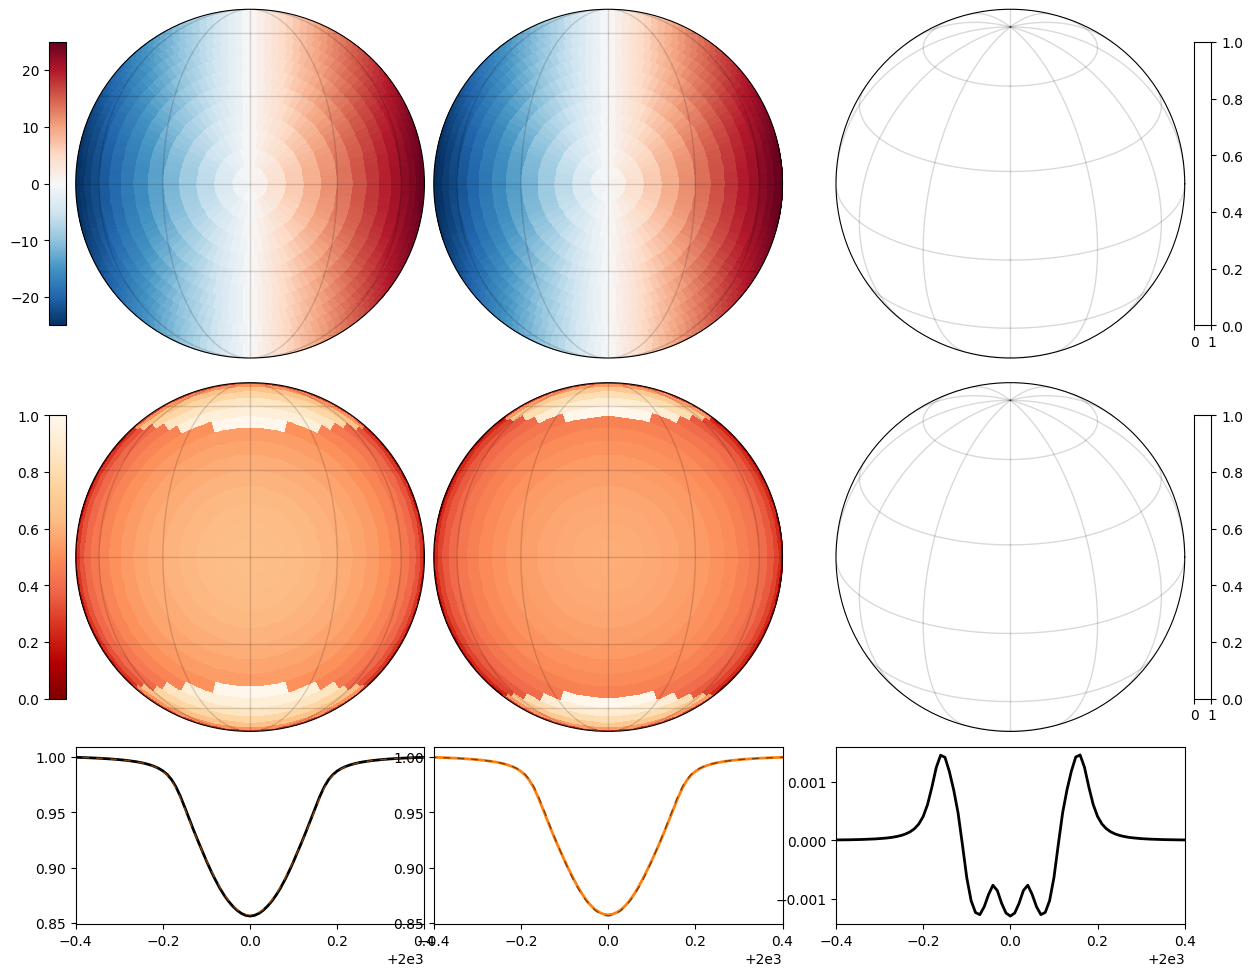

In [9]:
#for lon_0 in np.arange(0,180,2):
lon_0 = 0

fig = plt.figure(figsize=(15,12))
gs = fig.add_gridspec(
    nrows=7, ncols=6, hspace=0.05, wspace=0.05,
    height_ratios=[0.1,0.8,0.1,0.1,0.8,0.1,0.5], 
    width_ratios=[0.05,1,1,0.1,1,0.05], 
    )

ax  = np.array([
    fig.add_subplot(gs[0:3,1],projection='polar'),
    fig.add_subplot(gs[0:3,2],projection='polar'),
    fig.add_subplot(gs[0:3,4],projection='polar'),
    fig.add_subplot(gs[3:6,1],projection='polar'),
    fig.add_subplot(gs[3:6,2],projection='polar'),
    fig.add_subplot(gs[3:6,4],projection='polar'),
    ])
ax_profile = np.array([
    fig.add_subplot(gs[6,1]), 
    fig.add_subplot(gs[6,2]), 
    fig.add_subplot(gs[6,4]),
    ])
cax = np.array([
    fig.add_subplot(gs[1,0]), 
    fig.add_subplot(gs[1,5]), 
    fig.add_subplot(gs[4,0]), 
    fig.add_subplot(gs[4,5]), 
    ])

plot_map(ax[0], 'v_grid', Rot_1, cax=cax[0], cmap='RdBu_r', vmin=-25, vmax=25)
plot_map(ax[3], 'f_grid', Rot_1, cax=cax[2], cmap='OrRd_r', vmin=0, vmax=Rot_1.f_grid.max())
ax_profile[0].plot(wave, profile_broad_1, c='k', lw=2)
ax_profile[0].plot(wave, profile_broad_2, c='C1', lw=1, ls=(0,(5,5)), alpha=0.5)

plot_map(ax[1], 'v_grid', Rot_2, cax=cax[0], cmap='RdBu_r', vmin=-25, vmax=25)
plot_map(ax[4], 'f_grid', Rot_2, cax=cax[2], cmap='OrRd_r', vmin=0, vmax=Rot_2.f_grid.max())
ax_profile[1].plot(wave, profile_broad_2, c='C1', lw=2)
ax_profile[1].plot(wave, profile_broad_1, c='k', lw=1, ls=(0,(5,5)), alpha=0.5)

ax_profile[2].plot(wave, (profile_broad_1-profile_broad_2)/profile_broad_1, c='k', lw=2)

for i, ax_i in enumerate(ax.flatten()):
    ax_i.grid(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    ax_i.set_ylim(0,1)

    inc = 26
    if i in [0,3]:
        inc = bestfit_params_1['params']['inclination']
    if i in [1,4]:
        inc = bestfit_params_2['params']['inclination']
    plot_grid(ax_i, inclination=inc, lon_0=lon_0, c='k', alpha=0.15, lw=1)

for ax_i in ax_profile:
    #ax_i.axis('off')
    ax_i.set_xlim(2000-0.4,2000+0.4)
    #ax_i.set_ylim(0.85,1.02)

for cax_i in cax[[0,2]]:
    cax_i.yaxis.tick_left()
    cax_i.yaxis.set_label_position('left')
for cax_i in cax[[1,3]]:
    cax_i.yaxis.tick_right()
    cax_i.yaxis.set_label_position('right')

plt.show()

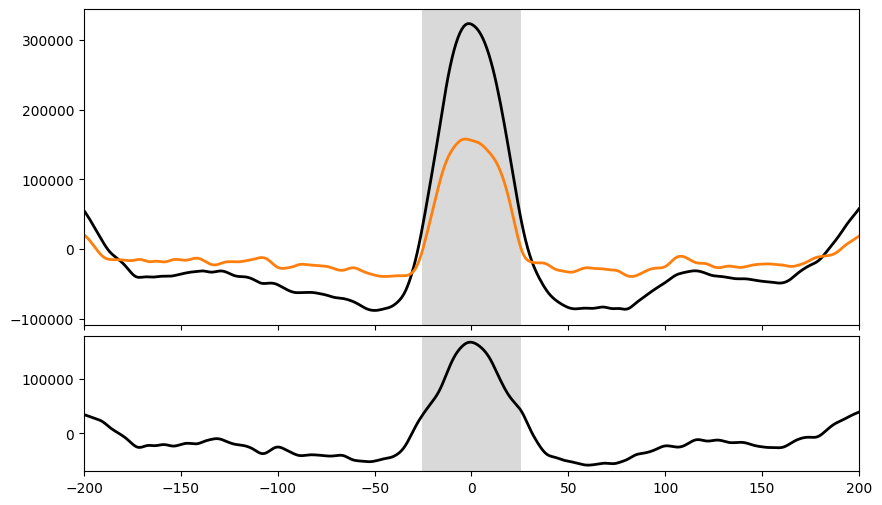

In [10]:
vsini = bestfit_params_2['params']['vsini']

height_ratio = [0.7,0.3]

fig, ax = plt.subplots(figsize=(10,6), nrows=2, sharex=True, gridspec_kw={'hspace':0.05, 'height_ratios':height_ratio})
ax[0].plot(rv, np.nansum(CCF_on_data_1, axis=(1,2)), c='k', lw=2)
ax[0].plot(rv, np.nansum(CCF_on_data_2, axis=(1,2)), c='C1', lw=2)
#ax[0].set(ylim=(-10000,12000))

#ylim = np.array(list(ax[0].get_ylim()))
#ylim = np.diff(ylim) * height_ratio[1]/height_ratio[0] * np.array([-1,1])
#ax[1].set(ylim=ylim)

ax[1].plot(rv, np.nansum(CCF_on_data_1, axis=(1,2))-np.nansum(CCF_on_data_2, axis=(1,2)), c='k', lw=2)

for ax_i in ax:
    ax_i.axvspan(xmin=-vsini, xmax=vsini, fc='k', ec='none', alpha=0.15)
    ax_i.set(xlim=(-200,200))
plt.show()

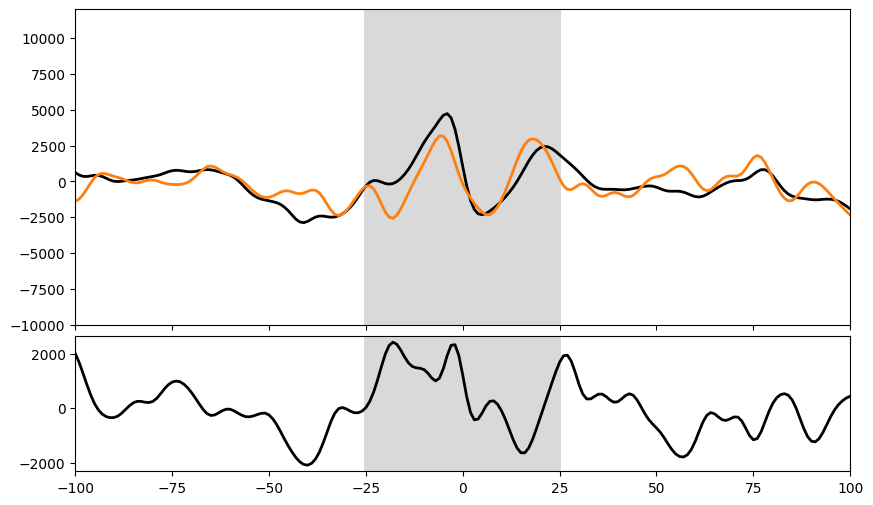

In [11]:
vsini = bestfit_params_2['params']['vsini']

height_ratio = [0.7,0.3]

fig, ax = plt.subplots(figsize=(10,6), nrows=2, sharex=True, gridspec_kw={'hspace':0.05, 'height_ratios':height_ratio})
ax[0].plot(rv, np.nansum(CCF_1, axis=(1,2)), c='k', lw=2)
ax[0].plot(rv, np.nansum(CCF_2, axis=(1,2)), c='C1', lw=2)
ax[0].set(ylim=(-10000,12000))

#ylim = np.array(list(ax[0].get_ylim()))
#ylim = np.diff(ylim) * height_ratio[1]/height_ratio[0] * np.array([-1,1])
#ax[1].set(ylim=ylim)

ax[1].plot(rv, np.nansum(CCF_1, axis=(1,2))-np.nansum(CCF_2, axis=(1,2)), c='k', lw=2)

for ax_i in ax:
    ax_i.axvspan(xmin=-vsini, xmax=vsini, fc='k', ec='none', alpha=0.15)
    ax_i.set(xlim=(-100,100))
plt.show()

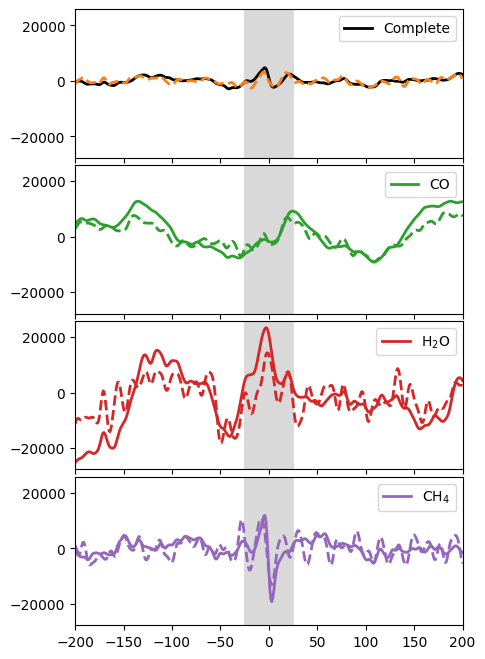

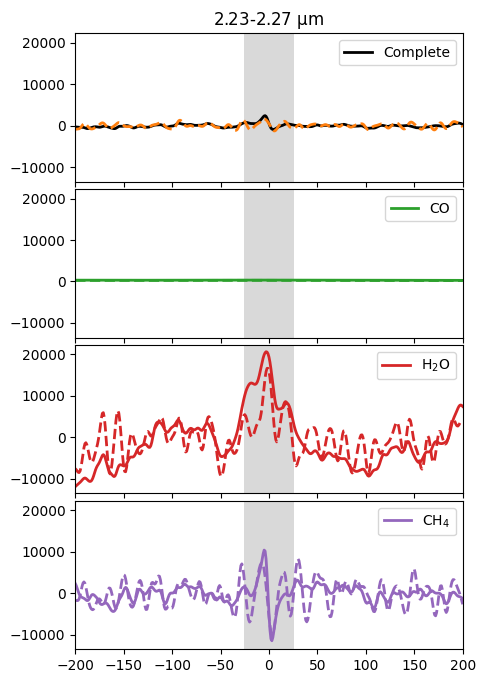

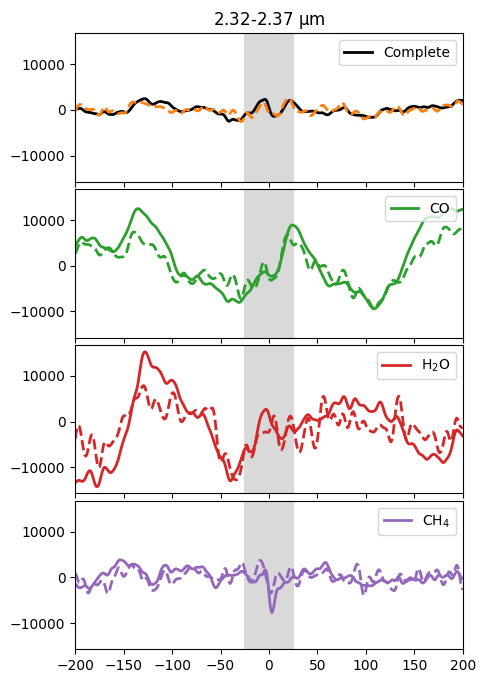

In [12]:
vsini = bestfit_params_2['params']['vsini']

fig, ax = plt.subplots(figsize=(5,8), nrows=4, sharex=True, sharey=True, 
                       gridspec_kw={'hspace':0.05})
ax[0].plot(rv, np.nansum(CCF_1, axis=(1,2)), c='k', lw=2, label='Complete')
ax[0].plot(rv, np.nansum(CCF_2, axis=(1,2)), c='C1', lw=2, ls='--')

ax[1].plot(rv, np.nansum(CCF_1_CO, axis=(1,2)), c='C2', lw=2, label=r'CO')
ax[1].plot(rv, np.nansum(CCF_2_CO, axis=(1,2)), c='C2', lw=2, ls='--')
ax[2].plot(rv, np.nansum(CCF_1_H2O, axis=(1,2)), c='C3', lw=2, label=r'H$_2$O')
ax[2].plot(rv, np.nansum(CCF_2_H2O, axis=(1,2)), c='C3', lw=2, ls='--')
ax[3].plot(rv, np.nansum(CCF_1_CH4, axis=(1,2)), c='C4', lw=2, label=r'CH$_4$')
ax[3].plot(rv, np.nansum(CCF_2_CH4, axis=(1,2)), c='C4', lw=2, ls='--')
#ax[4].plot(rv, np.nansum(CCF_NH3, axis=(1,2)), c='C8', lw=2, label=r'NH$_3$')

for ax_i in ax:
    ax_i.legend(loc='upper right')
    ax_i.axvspan(xmin=-vsini, xmax=vsini, fc='k', ec='none', alpha=0.15)
    ax_i.set(xlim=(-200,200))
plt.show()

ylim = np.array(list(ax_i.get_ylim()))
ylim /= 2
ylim = None

for i in range(d_spec_1.n_orders):

    wave_min = d_spec_1.wave[i].min()
    wave_max = d_spec_1.wave[i].max()

    fig, ax = plt.subplots(figsize=(5,8), nrows=4, sharex=True, sharey=True, 
                       gridspec_kw={'hspace':0.05})
    ax[0].plot(rv, np.nansum(CCF_1[:,i], axis=1), c='k', lw=2, label='Complete')
    ax[1].plot(rv, np.nansum(CCF_1_CO[:,i], axis=1), c='C2', lw=2, label=r'CO')
    ax[2].plot(rv, np.nansum(CCF_1_H2O[:,i], axis=1), c='C3', lw=2, label=r'H$_2$O')
    ax[3].plot(rv, np.nansum(CCF_1_CH4[:,i], axis=1), c='C4', lw=2, label=r'CH$_4$')

    for j in range(d_spec_2.n_orders):

        if (d_spec_2.wave[j].min() != wave_min) or (d_spec_2.wave[j].max() != wave_max):
            continue

        ax[0].plot(rv, np.nansum(CCF_2[:,j], axis=1), c='C1', lw=2, ls='--')
        ax[1].plot(rv, np.nansum(CCF_2_CO[:,j], axis=1), c='C2', lw=2, ls='--')
        ax[2].plot(rv, np.nansum(CCF_2_H2O[:,j], axis=1), c='C3', lw=2, ls='--')
        ax[3].plot(rv, np.nansum(CCF_2_CH4[:,j], axis=1), c='C4', lw=2, ls='--')

    for ax_i in ax:
        ax_i.legend(loc='upper right')
        ax_i.axvspan(xmin=-vsini, xmax=vsini, fc='k', ec='none', alpha=0.15)
        ax_i.set(xlim=(-200,200), ylim=ylim)
    ax[0].set(title='{:.2f}-{:.2f} '.format(wave_min/1e3,wave_max/1e3)+r'$\mathrm{\mu m}$')
    plt.show()